# Импорт библиотек

In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from pathlib import Path

In [199]:
train_dt = pd.read_excel("data/train.xlsx")
test_dt = pd.read_excel("data/test.xlsx")
combi_dt = pd.concat([train_dt, test_dt], ignore_index=True)  #объединяем оба датафрейма в один, игнорируя индексы, чтобы получить единый набор данных
combi_dt['dt'] = pd.to_datetime(combi_dt['dt'])  #преобразуем столбец 'dt' в формат даты, чтобы можно было сортировать и анализировать временные ряды
sorted_dt = combi_dt.sort_values(by='dt')  #сортируем данные по дате
sorted_dt = sorted_dt.drop_duplicates()  #убираем дубликаты
result_file = 'sorted.xlsx'
sorted_dt.to_excel(result_file, index=False)

In [200]:
combi_dt.shape 
print("\nПропущенные значения:")
print(combi_dt.isnull().sum())
print("\nКоличество дубликатов:")
print(combi_dt.duplicated().sum())
print("\nОписательная статистика:")
combi_dt.describe()  #среднее, стандартное отклонение, минимальное и максимальное значения


Пропущенные значения:
dt                  0
Цена на арматуру    0
dtype: int64

Количество дубликатов:
0

Описательная статистика:


,dt,Цена на арматуру
count,428,428.000000
mean,2019-02-07 12:00:00,39557.920561
min,2015-01-05 00:00:00,21000.000000
25%,2017-01-21 06:00:00,31650.000000
50%,2019-02-07 12:00:00,36150.000000
75%,2021-02-23 18:00:00,43162.500000
max,2023-03-13 00:00:00,79000.000000
std,NaN,13052.612976


смотрим список столбцов который прошел обработку и изначально загруженный

In [201]:
print("Столбцы в sorted_dt:", sorted_dt.columns)
print("Столбцы в test_dt:", test_dt.columns)

Столбцы в sorted_dt: Index(['dt', 'Цена на арматуру'], dtype='object')
Столбцы в test_dt: Index(['dt', 'Цена на арматуру'], dtype='object')


In [202]:
for df in [sorted_dt, test_dt]:
    df["dt"] = pd.to_datetime(df["dt"], errors='coerce')
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["day"] = df["dt"].dt.day
    df["week"] = df["dt"].dt.isocalendar().week
    df.drop(columns=["dt"], errors="ignore", inplace=True)

In [203]:
print(sorted_dt.columns)
sorted_dt = sorted_dt.sort_values(by=['year', 'month', 'day', 'week'])

Index(['Цена на арматуру', 'year', 'month', 'day', 'week'], dtype='object')


In [204]:
print(sorted_dt)

     Цена на арматуру  year  month  day  week
0               32900  2015      1    5     2
1               32500  2015      1   12     3
2               32000  2015      1   19     4
3               30700  2015      1   26     5
4               30300  2015      2    2     6
..                ...   ...    ...  ...   ...
423             44500  2023      2   13     7
424             46000  2023      2   20     8
425             49200  2023      2   27     9
426             53700  2023      3    6    10
427             55500  2023      3   13    11

[428 rows x 5 columns]


In [205]:
X = sorted_dt.drop(columns=['Цена на арматуру']).iloc[:-1, :]
y = sorted_dt['Цена на арматуру'].values[1:]
X['Price_target'] = y
X['Price_source'] = sorted_dt['Цена на арматуру'].values[:-1]
price_diff = X['Price_source'] - X['Price_target']
y = X['Price_target']
X = X.drop(columns=['Price_target'])
X = X.drop([0])
X['Price_Diff'] = price_diff.values[:-1]
X

,year,month,day,week,Price_source,Price_Diff
1,2015,1,12,3,32500,400
2,2015,1,19,4,32000,500
3,2015,1,26,5,30700,1300
4,2015,2,2,6,30300,400
5,2015,2,9,7,30300,0
...,...,...,...,...,...,...
422,2023,2,6,6,44500,-1700
423,2023,2,13,7,44500,0
424,2023,2,20,8,46000,-1500
425,2023,2,27,9,49200,-3200


In [206]:
print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")


Размер X: (426, 6)
Размер y: (427,)


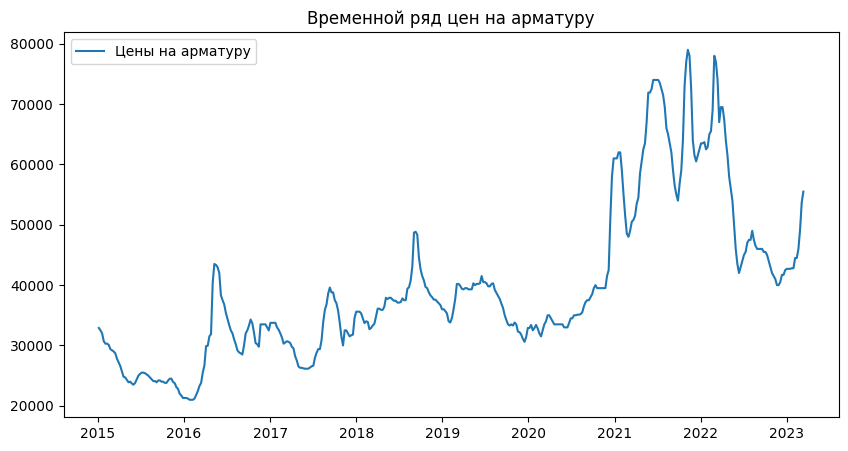

ADF Statistic: -1.9061951172076346
p-value: 0.329152368116511
Ряд нестационарный (p > 0.05), требуется дифференцирование


In [207]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Загружаем данные
df = pd.read_excel("sorted.xlsx", parse_dates=["dt"], index_col="dt")

# Визуализация временного ряда
plt.figure(figsize=(10,5))
plt.plot(df['Цена на арматуру'])  # Предполагается, что столбец с ценами называется 'price'
plt.title("Временной ряд цен на арматуру")
plt.legend(['Цены на арматуру'])
plt.show()

# ADF Test
price_series = df['Цена на арматуру']  # Замените 'price' на название вашего столбца с данными

adf_test = adfuller(price_series)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("Ряд стационарный (p < 0.05)")
else:
    print("Ряд нестационарный (p > 0.05), требуется дифференцирование")


In [208]:
df["diff"] = df["Цена на арматуру"].diff()
df.dropna(inplace=True)
#Повторный тест
adf_test = adfuller(df["diff"])
print(f"ADF Statistic после дифференцирования: {adf_test[0]}")
print(f"p-value после дифференцирования: {adf_test[1]}")

ADF Statistic после дифференцирования: -7.754587091983583
p-value после дифференцирования: 9.814435849356539e-12


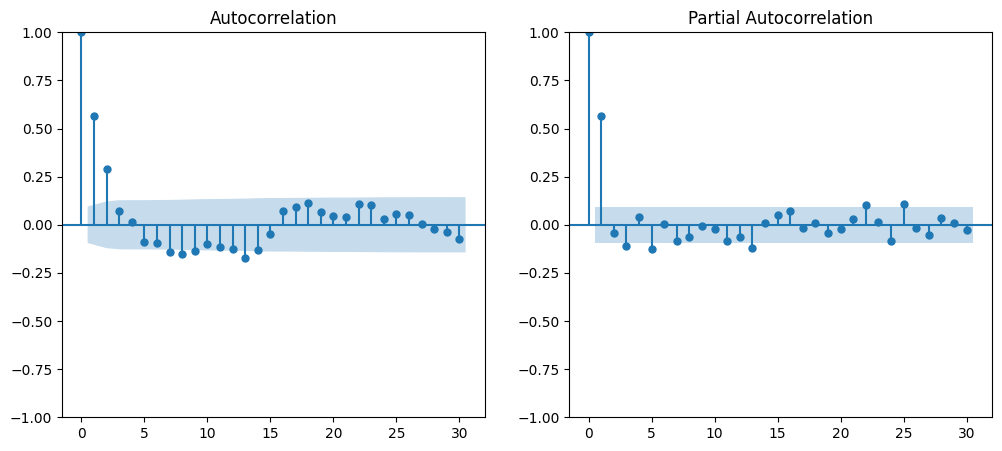

In [209]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# ACF - определяем q
plt.subplot(121)
plot_acf(df["diff"], lags=30, ax=plt.gca())

# PACF - определяем p
plt.subplot(122)
plot_pacf(df["diff"], lags=30, ax=plt.gca())  # исправлено lags вместо Lags

plt.show()


In [210]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import numpy as np

# Параметры для перебора
p_values = range(0, 6)  # Значения p: от 0 до 5
d_values = range(0, 2)  # Значения d: от 0 до 1 (обычно 0 или 1)
q_values = range(0, 6)  # Значения q: от 0 до 5

# Создаем все возможные комбинации
param_combinations = list(itertools.product(p_values, d_values, q_values))

# Инициализируем переменные для лучшей модели
best_mae = float("inf")
best_params = None
best_model = None

# Разделяем данные на train/test (например, 80% на обучение, 20% на тест)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Перебираем все комбинации
for params in param_combinations:
    try:
        # Обучаем модель ARIMA с текущими параметрами
        model = ARIMA(train["Цена на арматуру"], order=params)
        model_fit = model.fit()

        # Прогнозируем на тестовой выборке
        forecast = model_fit.forecast(steps=len(test))

        # Вычисляем MAE
        mae = mean_absolute_error(test["Цена на арматуру"], forecast)

        # Проверяем, является ли текущая модель лучшей
        if mae < best_mae:
            best_mae = mae
            best_params = params
            best_model = model_fit

    except Exception as e:
        # Если возникает ошибка при обучении модели, пропускаем эту комбинацию
        continue

# Выводим лучшие параметры и соответствующую метрику MAE
print(f"Лучшие параметры ARIMA: {best_params}")
print(f"Лучший MAE: {best_mae}")

# Выводим итоговую модель
print(best_model.summary())



c:\Users\annas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\annas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\annas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\annas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\annas\AppData\Local\Programs\Python

Лучшие параметры ARIMA: (3, 0, 0)
Лучший MAE: 5836.53301552356
                               SARIMAX Results                                
Dep. Variable:       Цена на арматуру   No. Observations:                  341
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2876.732
Date:                Tue, 25 Mar 2025   AIC                           5763.464
Time:                        14:36:57   BIC                           5782.623
Sample:                    01-12-2015   HQIC                          5771.097
                         - 07-19-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.568e+04   1.05e+04      3.391      0.001    1.51e+04    5.63e+04
ar.L1          1.5269      0.037     40.814      0.000       1.454  

In [211]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Обучаем модель
model = ARIMA(df["Цена на арматуру"], order=(3, 1, 2))
model_fit = model.fit()

# Выводим параметры модели
print(model_fit.summary())


c:\Users\annas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\annas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\annas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\annas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:

                               SARIMAX Results                                
Dep. Variable:       Цена на арматуру   No. Observations:                  427
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3709.521
Date:                Tue, 25 Mar 2025   AIC                           7431.042
Time:                        14:36:58   BIC                           7455.368
Sample:                    01-12-2015   HQIC                          7440.651
                         - 03-13-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4484      0.148      3.037      0.002       0.159       0.738
ar.L2          0.7605      0.168      4.526      0.000       0.431       1.090
ar.L3         -0.3765      0.049     -7.755      0.0

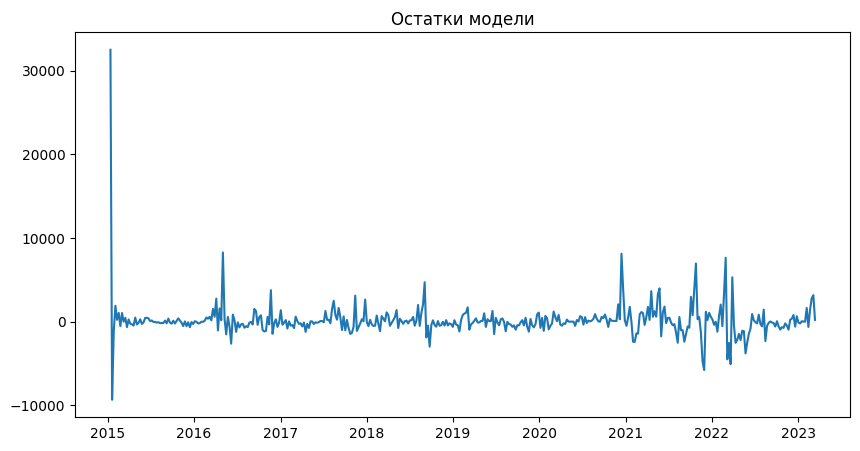

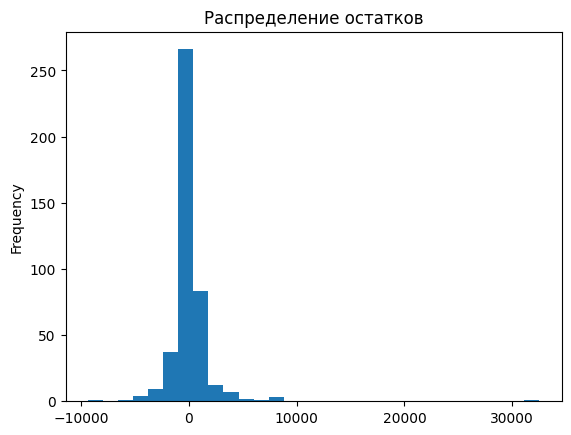

In [212]:
# График остатков
plt.figure(figsize=(10,5))
plt.plot(model_fit.resid)
plt.title("Остатки модели")
plt.show()

# Гистограмма остатков
model_fit.resid.plot(kind='hist', bins=30, title="Распределение остатков")
plt.show()


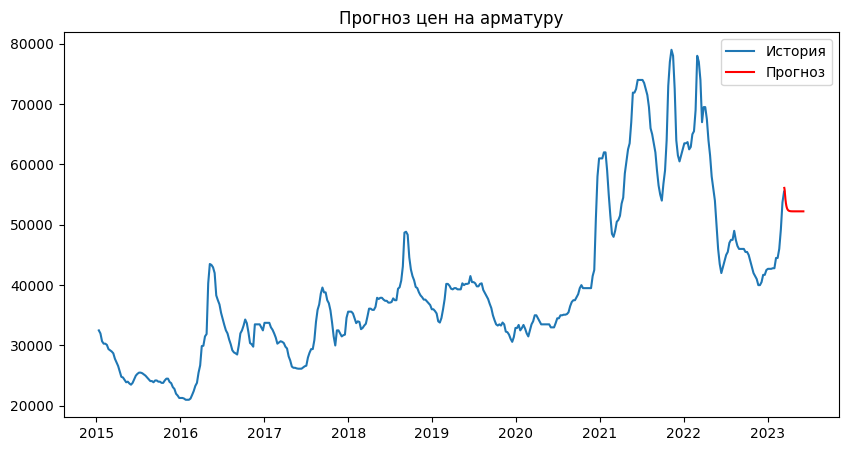

In [213]:
forecast_steps = 84  # Количество шагов в будущее
forecast = model_fit.forecast(steps=forecast_steps)

# Получаем прогнозированные значения
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Преобразуем прогноз в DataFrame
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=["Прогноз"])

# График прогноза
plt.figure(figsize=(10,5))
plt.plot(df.index, df["Цена на арматуру"], label="История")
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq="D")[1:], forecast, label="Прогноз", color="red")
plt.title("Прогноз цен на арматуру")
plt.legend()
plt.show()


In [214]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y = y[X.index]

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
model0 = LGBMRegressor(n_estimators=4000, max_depth=5, learning_rate=0.03,
                       objective='mae', metric='mae', verbose=10)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)
model0.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
           callbacks=[early_stopping(stopping_rounds=100)])

y_pred = model0.predict(X_valid)

y_pred_holdout = model0.predict(X_holdout)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")



[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.025123
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.001665 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 272, number of used features: 6
[LightGBM] [Info] Start training from score 33150.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further 

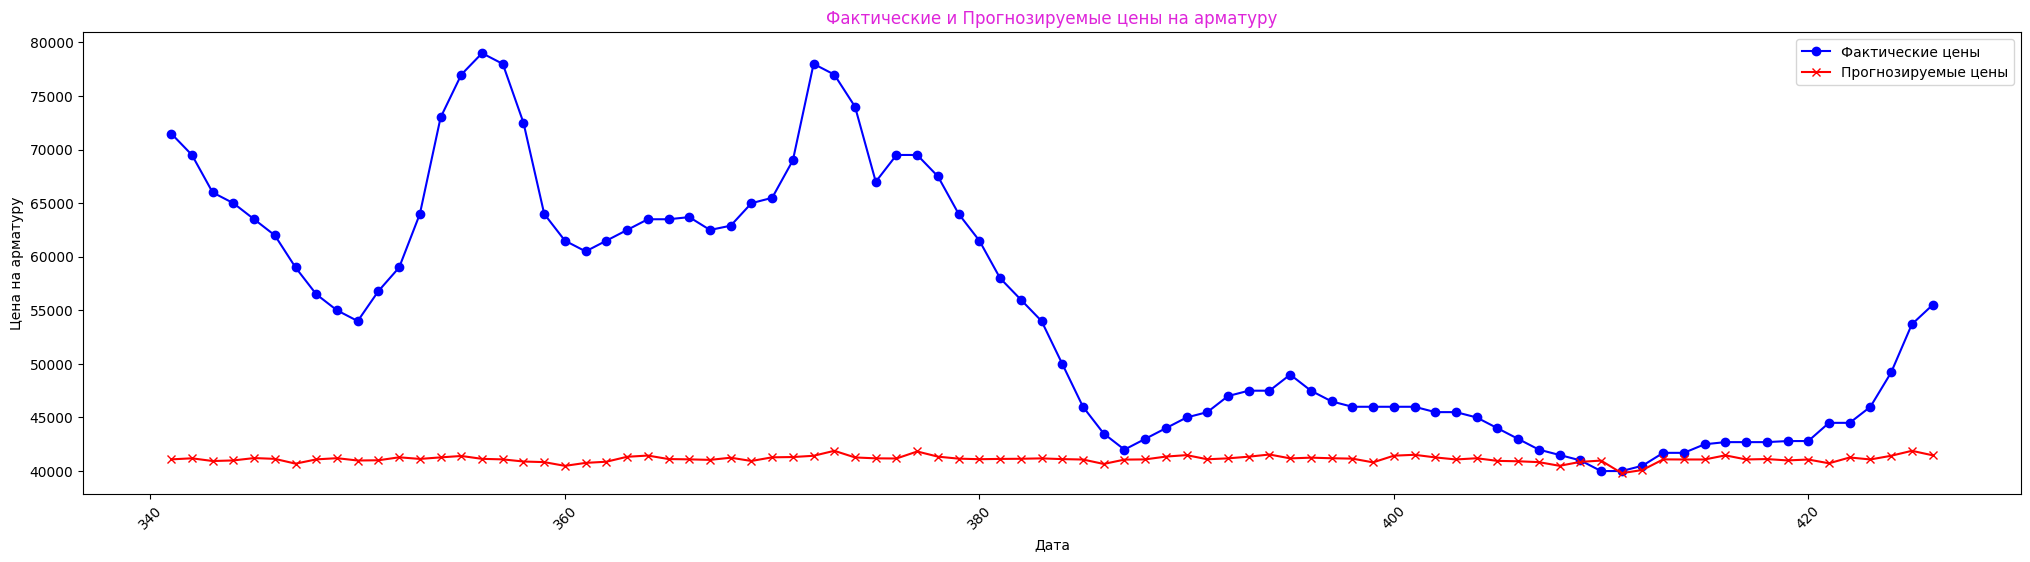

In [215]:
y_holdout = y_holdout.sort_index()
y_pred_holdout = pd.Series(y_pred_holdout, index=y_holdout.index).sort_index()

plt.figure(figsize=(25, 6))
plt.plot(y_holdout.index, y_holdout.values, label="Фактические цены", color='blue', marker='o')
plt.plot(y_holdout.index, y_pred_holdout, label="Прогнозируемые цены", color='red', marker='x')

plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Фактические и Прогнозируемые цены на арматуру", color='#de25da')
plt.xticks(rotation=45)
plt.show()

In [216]:
import joblib
joblib.dump(model0, "LGBMRegressor.pkl")

['LGBMRegressor.pkl']

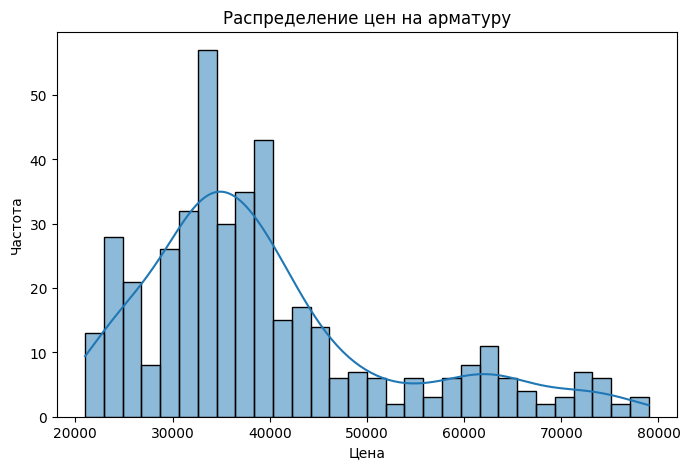

In [217]:
column = 'Цена на арматуру'
plt.figure(figsize=(8, 5))
sns.histplot(df[column], bins=30, kde=True)
plt.title("Распределение цен на арматуру")
plt.xlabel("Цена")
plt.ylabel("Частота")
plt.show()

In [218]:
print(df.columns)  # Выведет все столбцы DataFrame

Index(['Цена на арматуру', 'diff'], dtype='object')


In [219]:
# df['dt'] = pd.to_datetime(df['dt'])
# df.set_index('dt', inplace=True)
# plt.figure(figsize=(12, 6))
# plt.plot(df.index, df['Цена на арматуру'], label='Цена на арматуру', color='b')
# plt.title('Динамика цен на арматуру')
# plt.xlabel('Дата')
# plt.ylabel('Цена')
# plt.legend()
# plt.grid()
# plt.show()

In [220]:
# fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
# decompose = seasonal_decompose(df[['Цена на арматуру']])

# ax[0].set_title('Оригинал')
# ax[1].set_title('Тренд')
# ax[2].set_title('Сезонность')
# ax[3].set_title('Остаток')

# decompose.observed.plot(ax=ax[0])
# decompose.trend.plot(ax=ax[1])
# decompose.seasonal.plot(ax=ax[2])
# decompose.resid.plot(ax=ax[3]);

In [221]:
#print(df.columns)

In [222]:
#df['month'] = df.index.month
#plt.figure(figsize=(7, 5))
#sns.lineplot(x=df['month'], y=df['Цена на арматуру'], errorbar=None)
#plt.xlabel('Месяц')  # Подпись оси X
#plt.ylabel('Цена на арматуру')  # Подпись оси Y (возможно, здесь ошибка, так как строится цена на арматуру)
#plt.title('Сезонные изменения цен')  # Заголовок графика
#plt.xticks(range(1, 13), labels=[
    #'Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
    #'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
#plt.grid(True)
#plt.show()